<a href="http://www.stfc.ac.uk/"> <img src="../../img/STFCLargeColour.jpg" width="50%" align="left"/></a>
<a href="https://www.addopt.org/"><img src="../../img/ADDoPT-logo-MAIN-with-text.png" width="300" height="200" align="right"/></a>


# Choosing a Kernel

## The Gram matrix
Given a kernel function k and a list of molecules [m1, ...] the Gram Matrix is:

$$ [k(m_i, m_j)] $$

The job of a kernel function is to measure the similarity between the molecules.

In [2]:
import sys
sys.path.append('../../lib/')
import Kernel
from rdkit import Chem
from rdkit import Chem
from rdkit.Chem import Draw
# from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules


kernel = Kernel.MoleculeKernel()
kernel([Chem.MolFromSmiles('CO'), Chem.MolFromSmiles('CCO'), Chem.MolFromSmiles('CCCO')])

array([[1.        , 0.        , 0.16666667],
       [0.        , 1.        , 0.28571429],
       [0.16666667, 0.28571429, 1.        ]])

In [2]:
kernel([ Chem.MolFromSmiles('C(Cl)(Cl)(Cl)(Cl)'), 
        Chem.MolFromSmiles('C(Cl)(Cl)(Cl)(Br)'), 
        Chem.MolFromSmiles('C(Cl)(Cl)(Br)(Br)'), 
        Chem.MolFromSmiles('C(Cl)(Br)(Br)(Br)'),
        Chem.MolFromSmiles('C(Br)(Br)(Br)(Br)')
])

array([[1.        , 0.44444444, 0.25      , 0.08333333, 0.        ],
       [0.44444444, 1.        , 0.6       , 0.4       , 0.08333333],
       [0.25      , 0.6       , 1.        , 0.6       , 0.25      ],
       [0.08333333, 0.4       , 0.6       , 1.        , 0.44444444],
       [0.        , 0.08333333, 0.25      , 0.44444444, 1.        ]])


## Some Similarity measures


Previously we converted the molecules to a bit string "fingerprint". To measure the similarity between bit strings, we can use the Tanimoto similarity function:
$$  \frac {| x \land x' |}{| x \lor x' |}$$

     
This is related to the Jaccard similarity between two sets:
$$  \frac {| x \cap x' |}{| x \cup x' |}$$
     
The link is this: a fingerprint is bit array providing a compact, slightly inaccurate representation of a set. It uses a quasi-random hash function to convert a fragment to an integer. To get a fingerprint of size n it does
```
    fp = [0]*n
    foreach fragment in molecule:
       fp[hash(fragment)] = 1
```
The inaccuracy comes because of occasional collisions when two fragments hash to the same index.

RDKit offers a variety of similarity measures. In practice, Tanimoto is usually the best. For machine learning problems where other similarity measures perform better than Tanimoto, none perform well.

For nearest neighbour methods we used a distance function. This is preferably a valid metric function. In that case there are related similarity measures. Geographers use the Radial Basis Function:
$$\large     k(x, x') = e^\frac{-d(x, x')^2}{2\sigma^2}  $$
The influence of a training point on the prediction decays rapidly as the test point moves away from it. Here is an [example with sklearn](http://scikit-learn.org/stable/auto_examples/svm/plot_svm_nonlinear.html).

This is translation invariant. So if it is applied to chemical descriptors, it assumes that the difference between having two or three aromatic rings is as significant as the difference between zero and one. Since there is no such thing as a molecule with minus one aromatic rings, translation invariance does not feel appropriate.

### Exercise
Later, try alternative similarity measures in the [Support Vector Classifier](SVC.ipynb).
     
## The Kernel Trick

If the molecules are each represented by a vector of numerical features, then the dot product is also a valid similarity measure:
$$     k(x, x') = <x, x'> = \sum_{}^{} x_i \times x'_i  $$
This is rotation invariant. For example, it assumes that the number of aromatic rings has the same significance as the number of hydrogen bond donors. This also does not feel right for molecule descriptors.
     
The maths for OLS regression is stated in terms of dot products. This is true of many other machine learning methods. Any method which queries the training data only by means of dot products can be transformed into a kernel method by the substitution:
     $<x, x'> = k(x, x')$
This is called the "kernel trick". It is the root of fingerprint methods for machine learing.
     
## Requirements for a Kernel

To be a valid kernel, a function k must be:
* Symmetric: $k(x,x') = k(x',x)$
* Positive semidefinite (see aside)

If k1 and k2 are kernels, so are both of:
$$   k1 + k2 $$
$$   k1 \times k2 $$

## Mercer's Theorem 
If K is a kernel, in *reasonably well behaved cases*, then Mercer proved that there is a function $\phi$ and a vector space with a dot product $<,>$ such that

$$    K(x, x') = < \phi(x), \phi(x') > $$
    
So every kernel is equivalent to a list of features. The advantages of a kernel approach are:
* the kernel might be more efficient to compute
* the list of features may not be finite

<div class="panel panel-default"><div class="panel-heading">Aside for mathematicians</div>
<div class="panel-body">
A valid kernel must be positive semidefinite, i.e.
    i.e. $\forall (c_1 ... c_n) \in \mathbb{R}^n$: 
$$ \sum_{i=1}^{n} \sum_{j=1}^{n} k(x_i, x_j)c_i c_j \ge 0  $$
The classic example of such a function $\phi$ is the Fourier Series, which converts a periodic function into a list of Fourier coefficients. The kernel function for periodic functions on $[-\pi, \pi)$ is:
$$    K(f,g) = \int_{-\pi}^{\pi} f(x)g(x)dx $$
and the dot product in coefficient space is:
$$    {<\phi(f), \phi(g)>}  = \sum_{i=0}^{\infty}f_ig_i $$

*Reasonably well behaved* means: X is compact Hausdorff with a Borel measure in which k is bicontinuous.
</div></div>

## String Kernels

A protein sequence is a list of letters each representing one of the 20 amino acids. Sequences can be more or less similar. It's hard to make a fixed list of features that adequately represents sequences of different lengths. So let's make a kernel. For each protein, make the set of all subsequences:

$$    S: ACDM \to  \{ACDM, ACD, CD, CDM, DM\} $$
    
For any two proteins, use the Jaccard similarity between these sets. This is the "String Kernel". More generally, allowing gaps in the subsequences helps detect motifs. The weighted string kernel also uses a weighting function for subsequences w:s=>n. Then:

$$    W: S \to \sum_{s \in S}^{} w(s) $$
    
$$    k: p, p' \to \frac{W( S(p) \cap S(p')) }{ W( S(p)\cup S(p') } $$

String kernels are useful for machine learning in genomics.
    
## Graph Kernels

A molecule is represented by the familiar diagram. Mathematicians call this a "graph". Graphs have a richer structure than strings, so more kernels can be constructed. Here is formic acid:

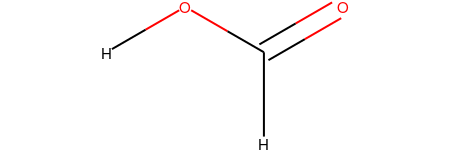

In [3]:
AllChem.AddHs(Chem.MolFromSmiles('OC=O'))

A molecule is a graph with atoms for nodes and bonds for edges. The path kernel is similar to the string kernel, using walks on the graph instead of subsequences. However, it is expensive to compute.  

Surprisingly, it is cheaper to compute the length of the shortest paths between atoms. This reduces e.g. formic acid (above) to 
```
   H1C  H2O H3H C1O C1H C2H O1C O2O O2H O3H H1O H2C H3O
```   
Then we can use the Jaccard similarity. The Atom Pairs Fingerprint which we used in the previous notebook extends this idea by:
* ignoring hydrogens
* annotating each atom with the number of heavy atom neighbours
* annotating each atom with the number of $\pi$ electrons.

## Molecule Fingerprints

A tree kernel uses not just a path. For each molecule it inds a tree routed at that molecule. Again, computing all the trees and then hashing them is expensive. Cleverly, a Morgan Fingerprint [hashes as it goes](http://pubs.acs.org/doi/pdf/10.1021/ci100050t), so it computes this efficiently. Below you can see a fragment with radius one and a fragment with radius two.

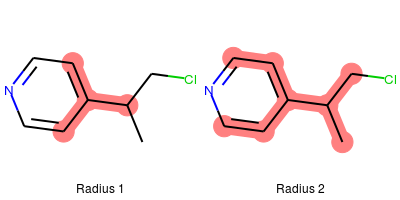

In [4]:

m = Chem.MolFromSmiles('c1cnccc1C(C)C(Cl)')
Draw.MolsToGridImage([m, m],legends=['Radius 1', 'Radius 2'],molsPerRow=2, 
    highlightAtomLists=[[4, 5, 0, 6], [0, 1, 3, 4, 5, 6, 7, 8]]
)

These fingerprints are a list of features. They find all features in the data, rather then being limited to predefined list, so this method can find new structural alerts.


## Tautomers

Different tautomers usually have different fingerprints. One way to make a model that is robust to tautomerization is to generate all tautomers for each molecule in the training set. A simpler method is to use this fingerprint:
```
    fingerprint = lambda m: RDKFingerprint(m, useBondOrder=False, useHs=False)
```
However, this will see no difference between e.g. CH2=CCH2Cl and CH3.C=CHCl. For some problems this will be unacceptable.

### Exercise

Try this tautomer-insensitive fingerprint in the [Support Vector Classifier](SVC.ipynb).

## Metrics

A kernel is a function indicating similarity. A nearest neighbour model uses a function indicating distance, preferably one that conforms to the definition of a metric. 

We can make a metric from any Mercer Kernel. The method is inspired by the metric on a vector space:

$$  d(x,x')^2 = <x-x',x-x'> = <x,x>-2<x,x'>+<x,x'> $$

so we use:
$$  d(x, x') = \sqrt{k(x,x)-2k(x,x')+k(x',x'}  $$
In the case of Tanimoto similarity this can be simplified because;
$$   \forall x:  d(x,x)=1$$

We can use this approach [to build a nearest neighbour model](../../Optional/Fingerprint-Nearest.ipynb).

Here is an example of a taxonomy built from  a metric based on the K-mer kernel by Onate et al.:
<div style="height:200px; position: relative; overflow: hidden">
<a href="https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-015-1406-7">
<img style="position:absolute; bottom: 0;"
src="http://media.springernature.com/full/springer-static/image/art%3A10.1186%2Fs12864-015-1406-7/MediaObjects/12864_2015_1406_Fig1_HTML.gif" />
</a></div>



## Further reading

For more information on the topics covered here:
    
- http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html
- Raymond E. Carhart, Dennis H. Smith, and R. Venkataraghavan [Atom pairs as molecular features in structure-activity studies: definition and applications
](http://pubs.acs.org/doi/abs/10.1021/ci00046a002)
- David Rogers and Mathew Hahn [High-Throughput Data Analysis. 1. Extended-Connectivity Fingerprints: A High-Dimensional Descriptor for Molecular Data Analysis](https://www.google.co.uk/url?sa=t&rct=j&q=&esrc=s&source=web&cd=4&cad=rja&uact=8&ved=0ahUKEwi6j9ST8qzXAhUNKuwKHQhhB4MQFgg-MAM&url=https%3A%2F%2Fwww.ics.uci.edu%2F~welling%2Fteaching%2FICS274Bspring06%2FDavid%2520Rogers%2520-%2520ECFP%2520Manuscript.doc&usg=AOvVaw2vJadzYHMwrn4evd2_z5oT)
- ALEX J. SMOLA and BERNHARD SCHOLKOPF [A tutorial on support vector regression](http://lasa.epfl.ch/teaching/lectures/ML_Phd/Notes/nu-SVM-SVR.pdf )
- [Fingerprints available in RDKit](http://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf)

The Gram Matrix is a high-dimensional set of features. Traditional statistical methods have trouble building good models with high dimensional input. [Next](SVM.ipynb) we will see a learning method that is free from the "curse of dimensionality".

[Up](../)

[Next](SVM.ipynb)

Copyright STFC 2018